In [1]:
"""
Notebook for testing the flipping + doubling of spectra on spectral accuracy/measurement of high-frequency 

"""


from scipy.io import loadmat
from scipy import signal
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings

%load_ext autoreload
%autoreload 2

In [12]:



#########################
#####Define Constants####
#########################
Cmax=10
uVpc = 1e6 * (10e-3 / (2**24))

Nfit=1
nstep_off=25
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 60 # I think this is the overlap?
#Andy sets navg (spectrum time windowing) to 120
navg = 120 #What is navg? I think this is the number of samples per window
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2

###########################


### Load Files ###
#For loading from harddrive
#fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
#For loading from laptop
fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
save_dir = "/Volumes/TFO-5TB-3/TFO/LCDRI/processed_data/James_output/Spectra/"
float_list = os.listdir(fname_base)


#float_list = ['6667i']
#Loop through every float_id
big_spec_store = []
big_time_store = []
big_up_down_store = []
big_prof_store = []
float_id_counter = 0
ignore_count = 0
too_deep_counter = 0
min_bin = []
resid_store = np.array([])

##Testing for nans
fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/6667i/dec/ema-6667i-0022-efr.mat"
gpsfname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/6667i/dec/ema-6667i-0022-gps.mat"
ctdfname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/6667i/dec/ema-6667i-0022-ctd.mat"


EFR = loadmat(fname)




efr_times = EFR['UXT'] - EFR['AGE']
efr_times = efr_times[0, :]
seqno = EFR['SEQNO'][0, :]

#Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
p = np.polyfit(seqno,efr_times,1)
pfit = np.poly1d(p)
mlt_efr = pfit(seqno);

GPS = loadmat(gpsfname)
CTD = loadmat(ctdfname)

     

ctd_time = CTD["UXT"][0, :]
P = CTD["P"][0, :]
Pef = np.interp(mlt_efr, ctd_time, P)

tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
#Convert time to fractional year for use in the igrf function
frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
avg_lat = np.nanmean(GPS["LAT"][0, :])
avg_lon = np.nanmean(GPS["LON"][0, :])
avg_frac_yrs = np.nanmean(frac_yrs)

#Get magnetic field values
[Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)

#get conversion factor for converting to velocity
fz=-np.nanmean(Bz);
fh=np.nanmean(np.sqrt(Bx**2+By**2));
sfv1 = 1e3/(fz*esep1*(1.0+c1));
sfv2 = 1e3/(fz*esep2*(1.0+c1));

#Convert from counts to microvolts
E1 = (EFR["E1"][0, :]-2**23) * uVpc;
E2 = (EFR["E2"][0, :]-2**23) * uVpc;

#pull out compass values
HZ = EFR["HZ"][0, :];
HY = EFR["HY"][0, :];
HX = EFR["HX"][0, :];
        

#Remove the beginning of the timesereis before the float starts moving
#Need to do this for all of E1, E2, HX, HY, mlt_efr
moving_inds = get_moving_inds(Pef)

#Uncomment this to print out the filenames where EM starts before CTD
#if len(moving_inds)<len(Pef):
    #print(len(Pef)-len(moving_inds), fname)
    #continue

#Apply moving_inds to the EM timeseries
E1 = E1[moving_inds]
E2 = E2[moving_inds]
HX = HX[moving_inds]
HY = HY[moving_inds]
mlt_efr = mlt_efr[moving_inds]
Pef_moving = Pef[moving_inds]
        
#Do the 50s fits 
[e1offs,e2offs,e1fits,e2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

#Get overall fi and calculate the residuals
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    e1off=np.nanmean(e1offs,1);
    e2off=np.nanmean(e2offs,1);
    e1fit=np.nanmean(e1fits,1);
    e2fit=np.nanmean(e2fits,1);
    resid = np.nanmean(resid,1);

#Calculate the residual
e1r = E1 - e1fit
e2r = E2 - e2fit

#Now need to convert to velocity (m/s)
e1r = e1r*sfv1
e2r = e2r*sfv2
        

#Now use the angles to rotate to x-y coordinates
avg_angs = np.copy(anghxhy)
avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    avg_angs = np.nanmean(avg_angs, axis=1)


E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs);
E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs);

E_x = E1_r
E_y = E2_r

#Now try highpass filtering the data
sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
E_x_filtered = signal.sosfilt(sos, E_x)
E_y_filtered = signal.sosfilt(sos, E_y)

E_x = E_x_filtered
E_y = E_y_filtered
        
    
##Get the mean residual level below 90m for the purpose of estimating error
deep_inds = np.where(Pef_moving>=90)
error = np.sqrt(np.square(e1r[deep_inds])+np.square(e2r[deep_inds]))
resid_store = np.append(resid_store, error)


#Now take the spectra
nblock = 120
fs = 1
overlap = 110




[u_x_temp, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)

[u_x, z_x] = reshape_u(E_x, Pef, nblock, overlap, fs)

#prof_speed is a numpy array that stores the mean vertical velocity (in m/s)
#for each spectral window
#Throwaway to get t_new in the same shape as u_x and z_x for calculating mean profiling speed

prof_speed = np.abs(z_x[:, 0]-z_x[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])


UUwindow, fwindow = make_vel_spectrum(u_x, fs)

[u_y, z_y] = reshape_u(E_y, Pef, nblock, overlap, fs)

VVwindow, fwindow = make_vel_spectrum(u_y, fs)


UU = UUwindow/(int(nblock/2)*fs)
Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
VV = VVwindow/(int(nblock/2)*fs)
Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

Eh = Exx+Eyy


[Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)

u_noise = 0 #This is just for testing...
[lbound, ubound] = get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs)

with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        avg_spec = np.nanmean(Eh_Eric4, axis=0)



/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_33428/3702935594.py:192: RuntimeWarning: invalid value encountered in true_divide
  prof_speed = np.abs(z_x[:, 0]-z_x[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])


In [13]:
#Try the flipping + the new spectral processing

new_Ex = np.append(E_x, -1*np.flip(E_x))
new_Ey = np.append(E_y, -1*np.flip(E_y))
new_P = np.append(Pef, np.flip(Pef))
new_mlt = np.append(mlt_efr, np.flip(mlt_efr))

[new_u_x, new_z_x] = reshape_u(new_Ex, new_P, nblock, overlap, fs)
[new_u_x_temp, new_t_new] = reshape_u(new_Ex, new_mlt, nblock, overlap, fs)
[new_u_y, new_z_y] = reshape_u(new_Ey, new_P, nblock, overlap, fs)

UUwindow, fwindow = make_vel_spectrum(new_u_x, fs)

VVwindow, fwindow = make_vel_spectrum(new_u_y, fs)


new_prof_speed = np.abs(new_z_x[:, 0]-new_z_x[:, -1])/np.abs(new_t_new[:, 0]-new_t_new[:, -1])



UU = UUwindow/(int(nblock/2)*fs)
Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
VV = VVwindow/(int(nblock/2)*fs)
Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

Eh_new = Exx+Eyy


[new_Eh_Eric1, new_Eh_Eric2, new_Eh_Eric3, new_Eh_Eric4] = depth_correct_Eric(Eh_new, fwindow[1:], new_z_x, new_prof_speed, nblock, Cmax, fs)

#u_noise = 0 #This is just for testing...
#[lbound, ubound] = get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs)

with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        new_avg_spec = np.nanmean(new_Eh_Eric4, axis=0)





/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_33428/1291071885.py:17: RuntimeWarning: invalid value encountered in true_divide
  new_prof_speed = np.abs(new_z_x[:, 0]-new_z_x[:, -1])/np.abs(new_t_new[:, 0]-new_t_new[:, -1])


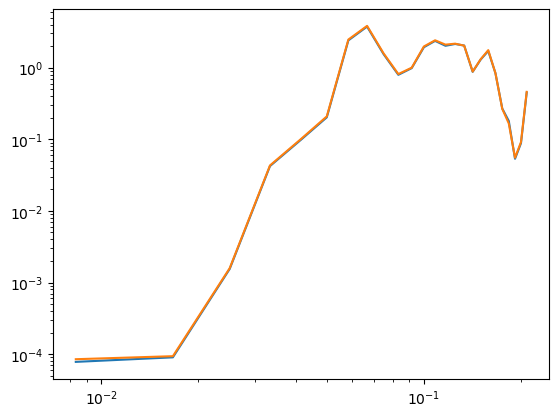

In [14]:
plt.loglog(fwindow[1:], new_avg_spec)
plt.loglog(fwindow[1:], avg_spec)

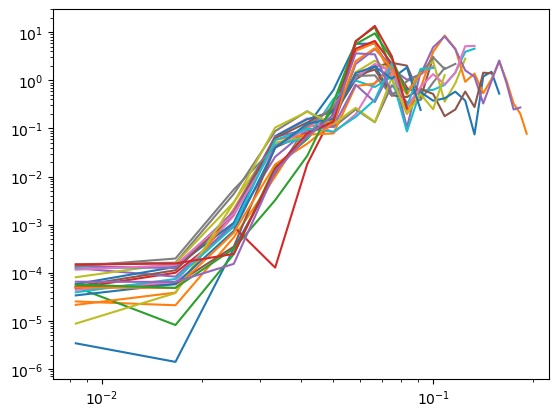

In [11]:
plt.loglog(fwindow[1:], np.transpose(new_Eh_Eric4))

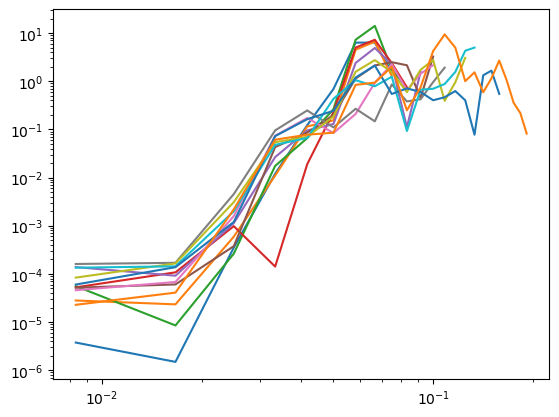

In [13]:
plt.loglog(fwindow[1:], np.transpose(Eh_Eric4))

In [8]:
mlt_efr-mlt_efr[0]

array([  0.        ,   1.02012801,   2.04025578,   3.0603838 ,
         4.08051181,   5.10063982,   6.12076783,   7.14089561,
         8.16102362,   9.18115163,  10.20127964,  11.22140765,
        12.24153566,  13.26166344,  14.28179145,  15.30191946,
        16.32204747,  17.34217548,  18.36230326,  19.38243127,
        20.40255928,  21.42268729,  22.4428153 ,  23.46294308,
        24.48307109,  25.5031991 ,  26.52332711,  27.54345512,
        28.56358314,  29.58371091,  30.60383892,  31.62396693,
        32.64409494,  33.66422296,  34.68435073,  35.70447874,
        36.72460675,  37.74473476,  38.76486278,  39.78499079,
        40.80511856,  41.82524657,  42.84537458,  43.8655026 ,
        44.88563061,  45.90575838,  46.92588639,  47.9460144 ,
        48.96614242,  49.98627043,  51.0063982 ,  52.02652621,
        53.04665422,  54.06678224,  55.08691025,  56.10703826,
        57.12716603,  58.14729404,  59.16742206,  60.18755007,
        61.20767808,  62.22780585,  63.24793386,  64.26

In [6]:
Pef_moving

array([101.50668478, 101.37504159, 101.24339842, 101.11175523,
       100.98011204, 100.84846884, 100.71682565, 100.58582718,
       100.45604201, 100.32625684, 100.19647168, 100.06668651,
        99.93690134,  99.80711621,  99.67733104,  99.54754587,
        99.41776071,  99.28797554,  99.15819041,  99.02840524,
        98.89862007,  98.76883491,  98.63904974,  98.5092646 ,
        98.37947944,  98.24958445,  98.11964287,  97.9897013 ,
        97.85975972,  97.72981817,  97.59987659,  97.46993502,
        97.33999344,  97.21005186,  97.08011031,  96.95016874,
        96.82022716,  96.69028558,  96.560344  ,  96.43040243,
        96.30046088,  96.1705193 ,  96.04057772,  95.91063615,
        95.78069457,  95.65075302,  95.52081144,  95.39117749,
        95.26320867,  95.13523984,  95.00727104,  94.87930221,
        94.75133338,  94.62336455,  94.49539573,  94.3674269 ,
        94.2394581 ,  94.11148927,  93.98352044,  93.85555162,
        93.72758279,  93.59961399,  93.47164516,  93.34

In [5]:
np.abs(t_new[:, 0]-t_new[:, -1])

array([121.39522815, 121.39522815, 121.39522815, 121.39522815,
       121.39522815, 121.39522815, 121.39522815, 121.39522815,
       121.39522815, 121.39522815, 121.39522815, 121.39522815,
       121.39522815, 121.39522815, 121.39522815, 121.39522815,
       121.39522815, 121.39522815, 121.39522815, 121.39522815,
       121.39522815, 121.39522815, 121.39522815, 121.39522815,
       121.39522815, 121.39522815, 121.39522815, 121.39522815,
       121.39522815, 121.39522815, 121.39522815, 121.39522815,
       121.39522815, 121.39522815, 121.39522815, 121.39522815,
       121.39522815, 121.39522815, 121.39522815, 121.39522815,
       121.39522815, 121.39522815, 121.39522815, 121.39522815,
       121.39522815, 121.39522815, 121.39522815, 121.39522815,
       121.39522815, 121.39522815, 121.39522815, 121.39522815,
       121.39522815, 121.39522815, 121.39522815, 121.39522815,
       121.39522815, 121.39522815, 121.39522815, 121.39522815,
       121.39522815, 121.39522815, 121.39522815, 121.39